In [2]:
%matplotlib inline

import pandas as pd

from matplotlib import pyplot as plt
from os.path import exists
from os import mkdir
from sklearn.datasets import load_files
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc

# Media 6 Degrees Exercise

1. Read in data, look at the variables and create a training and test set
2. Now build a model on all variables and look at coefficients and model fit
3. Get performance metrics on each variable
4. Create empty vectors to store the performance/evaluation metrics
5. Get MAE plot on single variable 
6. Greedy Forward Selection
7. Create empty vectors
8. Plot 3 AUC Curves

## Getting the data
* Read in data, look at the variables and create a training and test set

In [3]:
data_path = "dds_datasets/dds_ch5_binary-class-dataset.txt"


In [4]:
def csv2sklearn(data_path, destination='data', classes=[0, 1], target='y_buy', header=True, sep='\t'):
    '''Tool for translating csv data to sklearn dataset format. '''
    if not exists(destination):
        mkdir(destination)
    for class_type in classes:
        subclass_dir = '{}/{}'.format(destination, class_type)
        if not exists(subclass_dir):
            mkdir(subclass_dir)
    if header:    
        with open(data_path, 'r') as fp:
            for index, line in enumerate(fp):
                if index == 0:
                    header = line.strip().split(sep)
                else:
                    break
    try:
        target_index = header.index(target)
    except ValueError:
        raise ValueError('target does not exists.')
    
    with open(data_path, 'r') as fp:
        for index, line in enumerate(fp):
            if index > 0:
                values = line.split()
                target_value = values.pop(target_index)
                outfile = '{}/{}/{}'.format(destination, target_value, index)
                with open(outfile, 'w') as fw:
                    fw.write(sep.join(values))
                

In [5]:
#csv2sklearn(data_path)
#data = load_files('data')

Using pandas :heart:

In [6]:
data_df = pd.read_csv(data_path, sep='\t')
data_df.describe()

,at_buy_boolean,at_freq_buy,at_freq_last24_buy,at_freq_last24_sv,at_freq_last24_sv_int_buy,at_freq_sv,at_freq_sv_int_buy,at_interval_buy,at_interval_sv,at_interval_sv_int_buy,...,expected_time_sv_int_buy,last_buy,last_sv,last_sv_int_buy,multiple_buy,multiple_sv,multiple_sv_int_buy,uniq_content_links,num_checkins,y_buy
count,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,...,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000
mean,0.042632,0.052891,0.001942,0.117049,0.023542,1.852777,0.271636,0.210008,5.825610,0.381641,...,-0.953705,2.791221,64.729335,1.790671,0.006357,0.277444,0.032739,86.569343,720.657592,0.004635
std,0.202027,0.298157,0.051682,0.822048,0.483363,2.921820,2.206286,3.922016,17.595442,3.884156,...,9.792084,17.426907,53.476658,13.042733,0.079479,0.447742,0.177953,61.969765,1275.727306,0.067924
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-183.362600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,30.000000,127.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,51.000000,0.000000,0.000000,0.000000,0.000000,75.000000,319.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.104167,0.000000,...,0.000000,0.000000,105.000000,0.000000,0.000000,1.000000,0.000000,155.000000,802.000000,0.000000
max,1.000000,15.000000,4.000000,36.000000,36.000000,84.000000,75.000000,174.625000,184.916700,176.708300,...,88.300380,187.000000,188.000000,186.000000,1.000000,1.000000,1.000000,206.000000,37091.000000,1.000000


In [7]:
for column in sorted(data_df.columns):
    print(column)

at_buy_boolean
at_freq_buy
at_freq_last24_buy
at_freq_last24_sv
at_freq_last24_sv_int_buy
at_freq_sv
at_freq_sv_int_buy
at_interval_buy
at_interval_sv
at_interval_sv_int_buy
expected_time_buy
expected_time_sv
expected_time_sv_int_buy
last_buy
last_sv
last_sv_int_buy
multiple_buy
multiple_sv
multiple_sv_int_buy
num_checkins
uniq_content_links
y_buy


In [8]:
target_df = data_df[['y_buy']]
predictors_df = data_df.copy()
del predictors_df['y_buy']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(predictors_df, target_df)

In [10]:
X_train.describe()

,at_buy_boolean,at_freq_buy,at_freq_last24_buy,at_freq_last24_sv,at_freq_last24_sv_int_buy,at_freq_sv,at_freq_sv_int_buy,at_interval_buy,at_interval_sv,at_interval_sv_int_buy,...,expected_time_sv,expected_time_sv_int_buy,last_buy,last_sv,last_sv_int_buy,multiple_buy,multiple_sv,multiple_sv_int_buy,uniq_content_links,num_checkins
count,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,...,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000,40938.000000
mean,0.043847,0.054717,0.002150,0.118179,0.024598,1.869046,0.287899,0.220622,5.907264,0.399863,...,-10.232547,-0.972086,2.873345,64.710831,1.826347,0.006669,0.279154,0.033881,86.902340,720.720211
std,0.204757,0.307126,0.055437,0.818990,0.488283,2.986968,2.315824,4.031045,17.753775,4.063795,...,32.058220,9.915225,17.667466,53.472292,13.177566,0.081390,0.448589,0.180924,61.889615,1269.011749
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-186.026900,-183.362600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,30.000000,128.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,51.000000,0.000000,0.000000,0.000000,0.000000,76.000000,321.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.145833,0.000000,...,0.000000,0.000000,0.000000,105.000000,0.000000,0.000000,1.000000,0.000000,155.000000,803.750000
max,1.000000,15.000000,4.000000,36.000000,36.000000,84.000000,75.000000,174.625000,184.916700,176.708300,...,91.401920,88.300380,187.000000,187.000000,186.000000,1.000000,1.000000,1.000000,206.000000,37091.000000


In [11]:
y_train.describe()

,y_buy
count,40938.000000
mean,0.004788
std,0.069028
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [12]:
X_test.describe()

,at_buy_boolean,at_freq_buy,at_freq_last24_buy,at_freq_last24_sv,at_freq_last24_sv_int_buy,at_freq_sv,at_freq_sv_int_buy,at_interval_buy,at_interval_sv,at_interval_sv_int_buy,...,expected_time_sv,expected_time_sv_int_buy,last_buy,last_sv,last_sv_int_buy,multiple_buy,multiple_sv,multiple_sv_int_buy,uniq_content_links,num_checkins
count,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,...,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000,13646.000000
mean,0.038986,0.047413,0.001319,0.113660,0.020372,1.803972,0.222849,0.178165,5.580649,0.326978,...,-10.145502,-0.898561,2.544848,64.784845,1.683644,0.005423,0.272314,0.029313,85.570350,720.469735
std,0.193568,0.269403,0.038262,0.831177,0.468294,2.716542,1.838143,3.574985,17.109958,3.286383,...,31.339199,9.413140,16.682639,53.491673,12.629470,0.073443,0.445167,0.168688,62.201172,1295.712125
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-187.615600,-180.664300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,28.000000,122.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,51.000000,0.000000,0.000000,0.000000,0.000000,73.000000,312.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.041667,0.000000,...,0.000000,0.000000,0.000000,105.000000,0.000000,0.000000,1.000000,0.000000,154.000000,797.000000
max,1.000000,6.000000,2.000000,34.000000,28.000000,75.000000,68.000000,150.625000,183.083300,122.000000,...,90.376430,42.679900,186.000000,188.000000,182.000000,1.000000,1.000000,1.000000,202.000000,31649.000000


In [13]:
y_test.describe()

,y_buy
count,13646.000000
mean,0.004177
std,0.064497
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


* Now build a model on all variables and look at coefficients and model fit

In [14]:
clf = LogisticRegression()

In [15]:
clf.fit(X_train, y_train)

print('COEFF')
for predictor, coeff in sorted(list(zip(X_train.columns, clf.coef_.tolist()[0])), key = lambda tuple: tuple[1], reverse=True):
    print('\t{:28}: {}'.format(predictor, coeff))

print()
print('INTERCEPT')
print('\t{}'.format(clf.intercept_[0]))

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


COEFF
	at_freq_buy                 : 0.12321620487852782
	at_freq_sv_int_buy          : 0.07037349266547874
	last_sv_int_buy             : 0.061820537751198126
	expected_time_sv_int_buy    : 0.05085405034511118
	multiple_buy                : 0.04589056041929004
	multiple_sv_int_buy         : 0.021389954303113082
	at_freq_last24_sv           : 0.021229382500359783
	at_freq_last24_sv_int_buy   : 0.020282688848586437
	at_interval_sv              : 0.01367364226722867
	at_interval_buy             : 0.010604960312486502
	last_buy                    : 0.0040057464949142625
	num_checkins                : 4.932618464739538e-05
	expected_time_buy           : -0.004332748641821182
	uniq_content_links          : -0.008621880477820792
	at_interval_sv_int_buy      : -0.01296514119902634
	at_freq_last24_buy          : -0.03626646258184117
	at_freq_sv                  : -0.04283587848167373
	expected_time_sv            : -0.04893512016824949
	at_buy_boolean              : -0.07305376538239149
	last_s

In [16]:
accuracy_score(y_test, clf.predict(X_test))

0.99582295178074165

* Get performance metrics on each variable

In [20]:
fpr = {}
tpr = {}
roc_auc = {}

y_score = clf.predict(X_test)
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test.y_buy, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

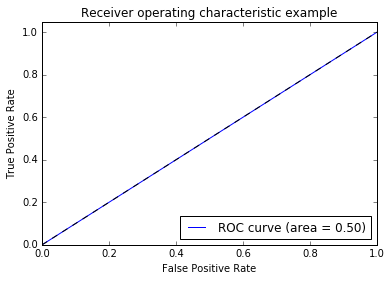

In [21]:
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [22]:
fpr

{0: array([ 0.,  1.]), 1: array([ 0.,  1.]), 2: array([ 0.,  1.])}

In [34]:
tpr

{0: array([ 0.,  0.,  1.]), 1: array([ 0.,  0.,  1.])}

In [35]:
roc_auc

{0: 0.49996317843729288, 1: 0.49996317843729288}

In [28]:
y_score

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
for truth, pred in zip(y_test.y_buy, y_score):
    print(truth, pred)

0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [41]:
from collections import Counter
Counter(y_score)

Counter({0: 13645, 1: 1})